<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Neural_Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyod --quiet

     |████████████████████████████████| 134 kB 7.0 MB/s 


In [3]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [4]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns
import timeit

Data Pre-processing

In [5]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [6]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [7]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [8]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)
assert test_df.shape == (449919, 52)


train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# following [Zhihan Li et al. KDD21] & [Dan Li. ICANN. 2019]
# fow SWaT data, due to the cold start of the system, starting point is 21600
train_df = train_df.iloc[21600:]


In [9]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [10]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [12]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [13]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

Model Prediction

In [14]:
from  pyod.models.deep_svdd import DeepSVDD
start = timeit.default_timer()
model = DeepSVDD(preprocessing = False,epochs=100, batch_size=128, hidden_neurons=[64, 32])
model.fit(train_scale)
end = timeit.default_timer()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 51)]              0         
                                                                 
 dense_1 (Dense)             (None, 64)                3264      
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_1 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_1 (TFOpL  (None,)                  0         
 ambda)                                                    

In [15]:
print(f"Total training time {end-start} s")

Total training time 1011.227686233 s


In [16]:
print(model.model_)

In [17]:
# get outlier scores
train_scores = model.decision_scores_  # raw outlier scores on the train data

start = timeit.default_timer()
test_scores = model.decision_function(test_scale)  # predict raw outlier scores on test
end = timeit.default_timer()

In [18]:
print(f'Total prediction time {end-start} s')

Total prediction time 20.96939227100006 s


In [19]:
pd.DataFrame(test_scores).describe()

0
count  449919.000000
mean     1665.857666
std      5897.221191
min         0.000001
25%         0.020566
50%         1.068469
75%         2.478198
max     24180.921875

In [20]:
pd.DataFrame(train_scores).describe()

0
count  475200.000000
mean        0.018568
std         0.007982
min         0.000010
25%         0.017316
50%         0.018063
75%         0.019112
max         1.492127

In [21]:
fpr, tpr, _ = metrics.roc_curve(label,  test_scores)
auc = metrics.roc_auc_score(label,  test_scores)

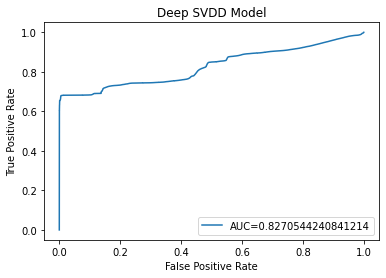

In [22]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Deep SVDD Model')
plt.legend(loc=4)
plt.show()

In [23]:
np.any(np.isnan(test_scores)),np.all(np.isfinite(test_scores))

(False, True)

In [24]:
#normalise error score
min_train = min(train_scores)
max_train = max(train_scores)
norm_train = (train_scores-min_train)/(max_train-min_train)

In [25]:
norm_test = (test_scores - min_train)/(max_train-min_train)

In [26]:
df_error_train = pd.DataFrame(norm_train,columns = ['error'])
df_error_train['type'] = 'train'
df_error_test = pd.DataFrame(norm_test,columns = ['error'])
df_error_test['type'] = 'test'

pd.concat([df_error_train,df_error_test]).to_csv("/content/drive/MyDrive/Data_sci_Project/error.csv")

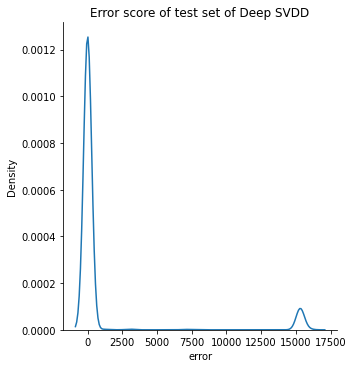

In [27]:
# sns.displot(df_error_train, x="error",kind="kde")
sns.displot(df_error_test, x="error",kind="kde")
plt.title("Error score of test set of Deep SVDD")
plt.show()

In [28]:
threshold= np.percentile(norm_test,92)
threshold

16.69113143920898

In [29]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    pred_label[i:i+time_window] = 0
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
  return pred_label

In [30]:
time_window = 10
pred_label = pred_labels_timewindow(norm_test,threshold,time_window)

In [31]:
print(metrics.classification_report(label,pred_label))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    395298
           1       0.99      0.65      0.79     54621

    accuracy                           0.96    449919
   macro avg       0.97      0.83      0.88    449919
weighted avg       0.96      0.96      0.95    449919



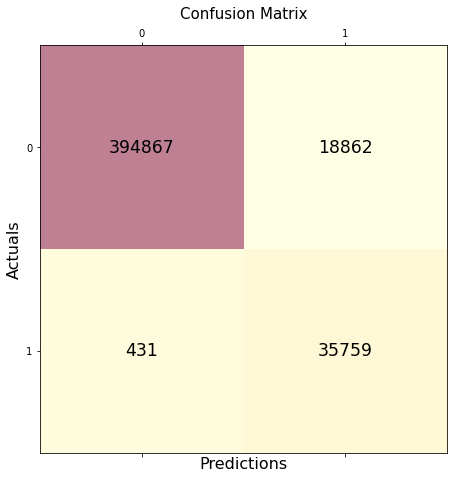

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label,pred_label)

# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(cm, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(cm.shape[0]):
    for n in range(cm.shape[1]):
        px.text(x=m,y=n,s=cm[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [33]:
time_label = pd.DataFrame(pred_label, index= test_df.index, columns = ['pred'])

In [34]:
time_label['label'] = label
time_label.reset_index(inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label.Timestamp)

true anomaly

In [35]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [36]:
start_time = true_anomaly['Start Time'][~true_anomaly["End Time"].isnull()]
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [37]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [38]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [52]:
attack_lenght

0       939
1       442
2       382
3       389
5       195
6       428
7       963
9       160
10      560
12      232
13      430
15      275
16      716
18      258
19      394
20      720
21      462
22      696
23      320
24      611
25     1444
26     1690
27    34208
28      120
29     1170
30      366
31      600
32      443
33      100
34      480
35      539
36      468
37      280
38      400
39      296
40     1674
dtype: int64

In [39]:
len(start_time) #there are 36 attack

36

In [40]:
start_time.index.values+1

array([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 14, 16, 17, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41])

In [41]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [42]:
time_label['attack #'] = 0
for i in range (len(idx_start)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = attack_lenght.index.values[i]+1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0, 0.5, 'normal/attack')

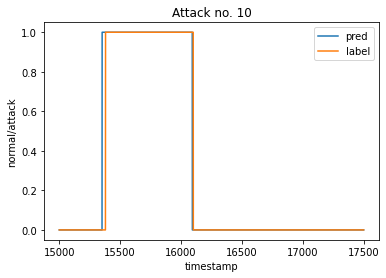

In [43]:
plt.plot(time_label.loc[15000:17500].index,time_label.loc[15000:17500]["pred"])
plt.plot(time_label.loc[15000:17500].index,time_label.loc[15000:17500]["label"])
plt.title('Attack no. 10')
plt.legend(["pred", "label"])
plt.xlabel("timestamp")
plt.ylabel("normal/attack")

Text(0.5, 1.0, 'attack 1-8')

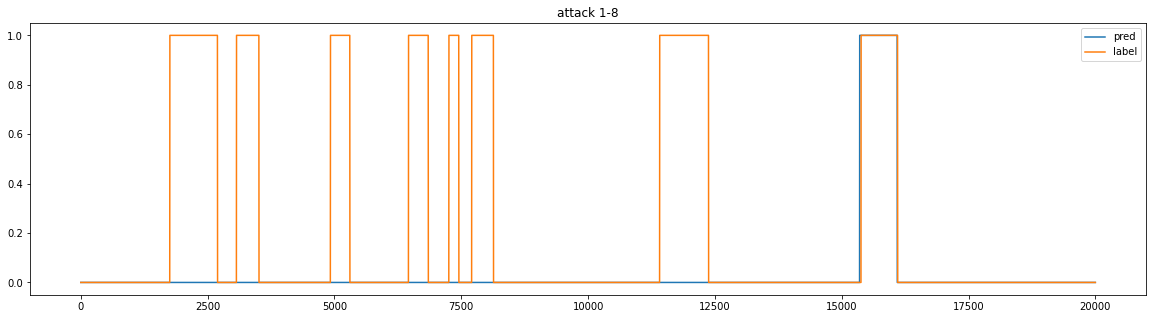

In [44]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[:20000],time_label["pred"][:20000])
plt.plot(time_label.index[:20000],time_label["label"][:20000])
plt.legend(["pred", "label"])
plt.title('attack 1-8')

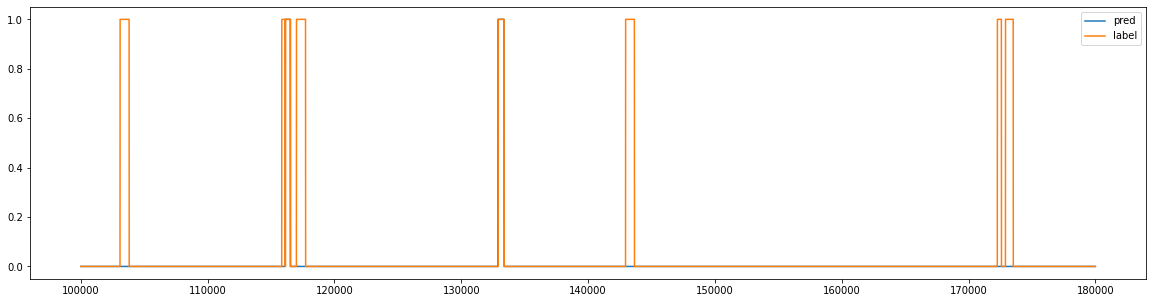

In [45]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[100000:180000],time_label["pred"][100000:180000])
plt.plot(time_label.index[100000:180000],time_label["label"][100000:180000])
plt.legend(["pred", "label"])

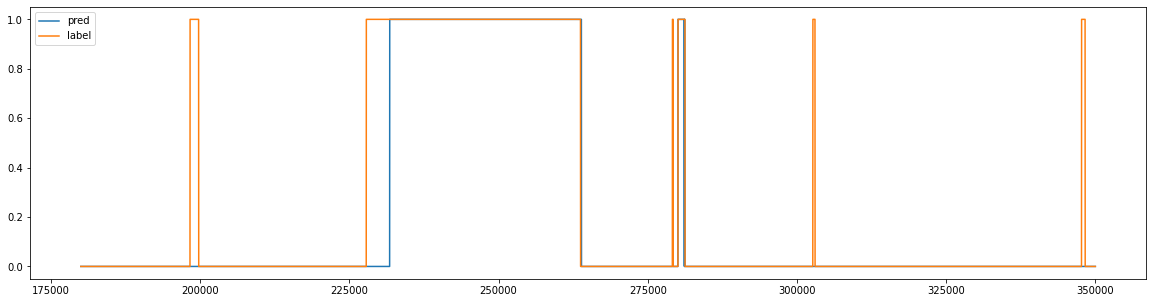

In [46]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[180000:350000],time_label["pred"][180000:350000])
plt.plot(time_label.index[180000:350000],time_label["label"][180000:350000])
plt.legend(["pred", "label"])

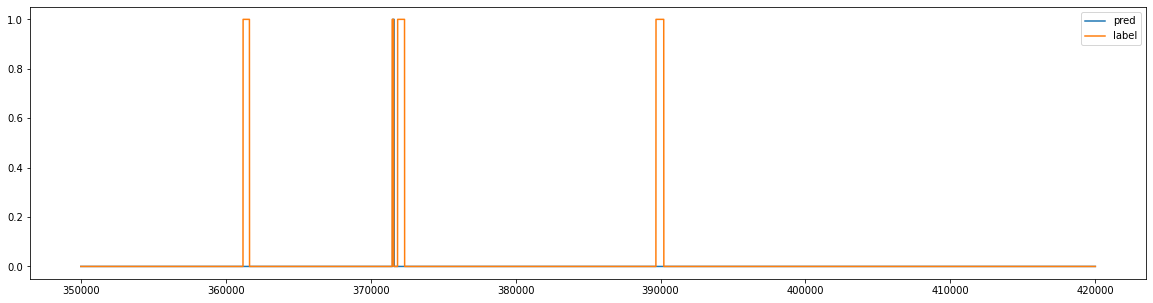

In [47]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[350000:420000],time_label["pred"][350000:420000])
plt.plot(time_label.index[350000:420000],time_label["label"][350000:420000])
plt.legend(["pred", "label"])

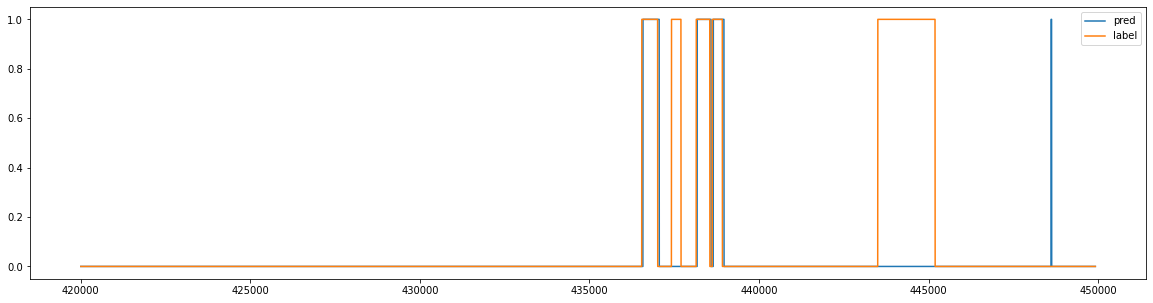

In [48]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[420000:],time_label["pred"][420000:])
plt.plot(time_label.index[420000:],time_label["label"][420000:])
plt.legend(["pred", "label"])

Find attack no. that model found

In [49]:
found = []
for i in range(len(time_label)):
  if (time_label.loc[i]["pred"] == 1) & (time_label.loc[i]["label"] == 1):
    found.append(time_label.loc[i]["attack #"])

In [50]:
np.unique(found)

array([10, 11, 20, 22, 28, 30, 34, 37, 39, 40])

In [51]:
print(f"There are {len(np.unique(found))} attacks found")

There are 10 attacks found


Apply XAI

##CASE STUDY attack no.1
model cannot detect the anomaly point

### SHAP

In [53]:
!pip install shap --quiet

     |████████████████████████████████| 569 kB 8.2 MB/s 


In [54]:
import shap

In [56]:
#summarize all the train data using shap.kmeans
X_train_summary = shap.kmeans(train_scale, 50)

In [57]:
shap_explainer = shap.KernelExplainer(model=model.model_.predict, data=X_train_summary)

In [58]:
#attack no.1
#sample data  in attack no.1 for 100 instance
sample = shap.sample(test_scale[idx_start[0]:idx_end[0]], 100)

In [59]:
np.any(np.isnan(sample)), np.all(np.isfinite(sample))

(False, True)

In [60]:
start = timeit.default_timer()
shap_values_1 = shap_explainer.shap_values(X=sample, nsamples=100)
end = timeit.default_timer()

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [61]:
print(end-start)

61.08486343300001


Single value

In [62]:
sample1 = shap.sample(test_scale[idx_start[0]:idx_end[0]], 1)

In [63]:
start = timeit.default_timer()
shap_value_single = shap_explainer.shap_values(X = sample1, nsamples = 100)
end = timeit.default_timer()

  0%|          | 0/1 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


In [64]:
print(end-start)

0.7323585870001352


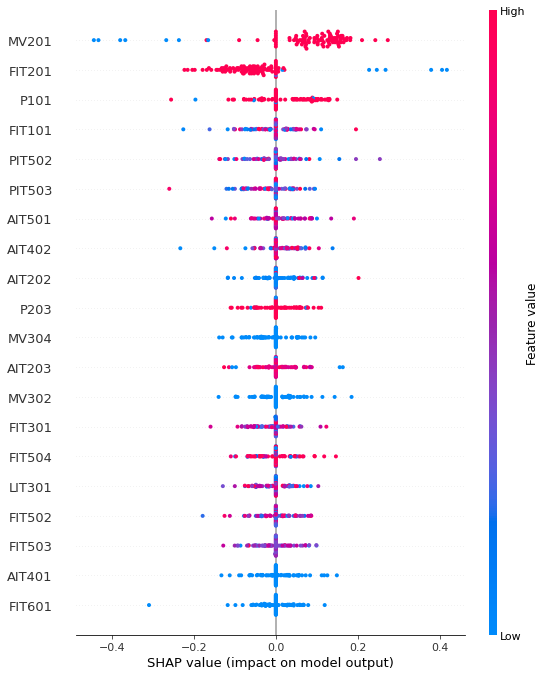

In [65]:
shap.initjs()
shap.summary_plot(shap_values_1, sample)

In [66]:
shap_result = pd.DataFrame(np.mean(shap_values_1,axis=0), index= train_scale.columns, columns = ["result"])
shap_result.sort_values(by = ["result"])

result
FIT201  -0.044227
PIT503  -0.011323
FIT301  -0.010191
FIT401  -0.009869
MV304   -0.009681
MV101   -0.007905
LIT101  -0.007521
FIT101  -0.005863
AIT201  -0.005304
PIT501  -0.004007
FIT601  -0.003572
LIT301  -0.003348
FIT503  -0.003184
PIT502  -0.002658
FIT504  -0.001785
AIT502  -0.001729
FIT502  -0.001249
P205    -0.001171
LIT401  -0.001106
AIT503  -0.000641
DPIT301 -0.000210
P501     0.000000
P502     0.000000
UV401    0.000000
P601     0.000000
P404     0.000000
P403     0.000000
P402     0.000000
P401     0.000000
P603     0.000000
P204     0.000000
P301     0.000000
P102     0.000000
P201     0.000000
P206     0.000000
P202     0.000000
MV303    0.000090
FIT501   0.001822
AIT504   0.002713
AIT203   0.002943
P302     0.002996
AIT401   0.003034
P203     0.003089
P602     0.003172
MV302    0.003253
MV301    0.004135
AIT501   0.005954
AIT402   0.006639
AIT202   0.007865
P101     0.020359
MV201    0.068247

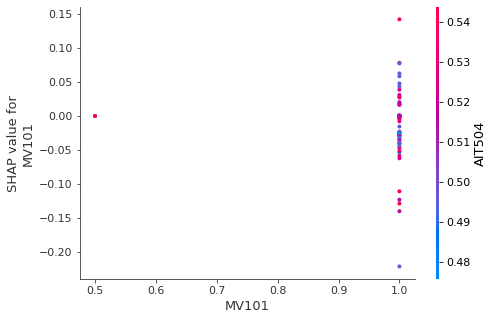

In [67]:
shap.dependence_plot("MV101", shap_values_1, sample)

### LIME

In [68]:
!pip install lime --quiet

     |████████████████████████████████| 275 kB 9.2 MB/s 


In [69]:
import lime
import lime.lime_tabular
from lime import submodular_pick

In [70]:
lime = lime.lime_tabular.LimeTabularExplainer(X_train_summary.data, feature_names=train_scale.columns,
                                                   verbose=True, mode='regression')

In [72]:
start = timeit.default_timer()
a = lime.explain_instance(sample.iloc[10], model.decision_function, num_features=20)
end = timeit.default_timer()

Intercept 1.377006913094602
Prediction_local [0.22121629]
Right: 0.018089578


In [73]:
print(end-start)

23.517767563999996


In [74]:
a.show_in_notebook(show_table=False)

In [75]:
start = timeit.default_timer()
sp_obj = submodular_pick.SubmodularPick(lime, sample.values, model.decision_function, num_features=20,num_exps_desired=1)
end = timeit.default_timer()

Requested sample size larger than
                              size of input data. Using all data


Intercept 1.3739227652148895
Prediction_local [0.20018217]
Right: 0.0184345
Intercept 1.1374596148945857
Prediction_local [0.20673886]
Right: 0.018474063
Intercept 1.4326441429966696
Prediction_local [0.22599529]
Right: 0.018644724
Intercept 1.3287686289097698
Prediction_local [-0.01244193]
Right: 0.018291568
Intercept 1.2225805143327422
Prediction_local [0.13946771]
Right: 0.017886486
Intercept 1.336714470555648
Prediction_local [0.05599857]
Right: 0.018372245
Intercept 1.406324695501517
Prediction_local [0.09227146]
Right: 0.01795093
Intercept 1.2884385186593164
Prediction_local [0.14685281]
Right: 0.018430777
Intercept 1.1353955757327348
Prediction_local [0.20621462]
Right: 0.018505082
Intercept 1.433677642181041
Prediction_local [0.17449077]
Right: 0.017917566
Intercept 1.2958851518401844
Prediction_local [0.0469285]
Right: 0.017908143
Intercept 1.419908288916065
Prediction_local [0.06668952]
Right: 0.017944664
Intercept 1.1180645322609648
Prediction_local [0.14812822]
Right: 0.017

In [76]:
print(end-start)

2407.844583164


[<Figure size 432x288 with 1 Axes>]

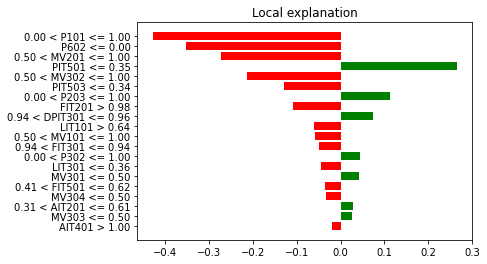

In [77]:
[exp.as_pyplot_figure(label=0) for exp in sp_obj.sp_explanations]

In [78]:
sp_obj.sp_explanations[0].as_list()

[('0.00 < P101 <= 1.00', -0.42873968872129725),
 ('P602 <= 0.00', -0.351960734456039),
 ('0.50 < MV201 <= 1.00', -0.27304469522138003),
 ('PIT501 <= 0.35', 0.26580626633819304),
 ('0.50 < MV302 <= 1.00', -0.21453852764880538),
 ('PIT503 <= 0.34', -0.12799124290729844),
 ('0.00 < P203 <= 1.00', 0.11291704912238917),
 ('FIT201 > 0.98', -0.10963487110720675),
 ('0.94 < DPIT301 <= 0.96', 0.07314140837630326),
 ('LIT101 > 0.64', -0.06149598052887281),
 ('0.50 < MV101 <= 1.00', -0.05813330137529607),
 ('0.94 < FIT301 <= 0.94', -0.049101905621941964),
 ('0.00 < P302 <= 1.00', 0.045334884919262027),
 ('LIT301 <= 0.36', -0.04513401054616837),
 ('MV301 <= 0.50', 0.042929229657789246),
 ('0.41 < FIT501 <= 0.62', -0.03480404824322182),
 ('MV304 <= 0.50', -0.03223541001768397),
 ('0.31 < AIT201 <= 0.61', 0.028054583411429752),
 ('MV303 <= 0.50', 0.02561531539467699),
 ('AIT401 > 1.00', -0.01929755039150207)]

###IntegratedGradients

In [79]:
!pip install alibi[tensorflow] --quiet

     |████████████████████████████████| 445 kB 8.1 MB/s 
     |████████████████████████████████| 60 kB 6.7 MB/s 
     |████████████████████████████████| 4.7 MB 49.5 MB/s 
     |████████████████████████████████| 98.5 MB 1.2 MB/s 
     |████████████████████████████████| 101 kB 11.0 MB/s 
     |████████████████████████████████| 596 kB 66.8 MB/s 
     |████████████████████████████████| 6.6 MB 45.9 MB/s 


In [80]:
from alibi.explainers import IntegratedGradients
import tensorflow as tf

In [81]:
ig  = IntegratedGradients(model.model_,
                          layer=None,
                          target_fn=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)

In [82]:
start = timeit.default_timer()
ig_explanation = ig.explain(sample.to_numpy(),
                         baselines=None,
                         target=[0]*len(sample))
end = timeit.default_timer()

In [83]:
print(end-start)

5.341108779000024


In [84]:
attributions = ig_explanation.attributions

In [85]:
ig_result = pd.DataFrame(np.mean(attributions[0],axis=0), index= train_scale.columns, columns = ["result"])

In [86]:
ig_result.sort_values(by = ["result"], ascending=False)

result
MV201    4.556775
P203     0.253951
PIT501   0.107341
FIT501   0.047332
AIT504   0.034816
MV301    0.029899
MV101    0.029648
MV302    0.028691
FIT503   0.018738
FIT504   0.017612
AIT501   0.015701
FIT301   0.014480
MV304    0.011790
AIT401   0.008723
LIT101   0.008371
FIT502   0.004507
FIT401   0.001899
AIT402   0.000821
AIT502   0.000583
AIT203   0.000379
LIT301   0.000089
P402     0.000000
P501     0.000000
P502     0.000000
P601     0.000000
P602     0.000000
UV401    0.000000
P404     0.000000
P403     0.000000
P603     0.000000
P401     0.000000
P206     0.000000
P102     0.000000
P201     0.000000
P204     0.000000
P202     0.000000
P301     0.000000
FIT601  -0.000004
P205    -0.000440
AIT201  -0.000481
AIT202  -0.000720
PIT502  -0.001616
MV303   -0.002357
LIT401  -0.002365
DPIT301 -0.002795
AIT503  -0.004705
FIT101  -0.009593
P302    -0.013402
PIT503  -0.078945
FIT201  -0.265060
P101    -2.192755

Text(0.5, 0, 'feature')

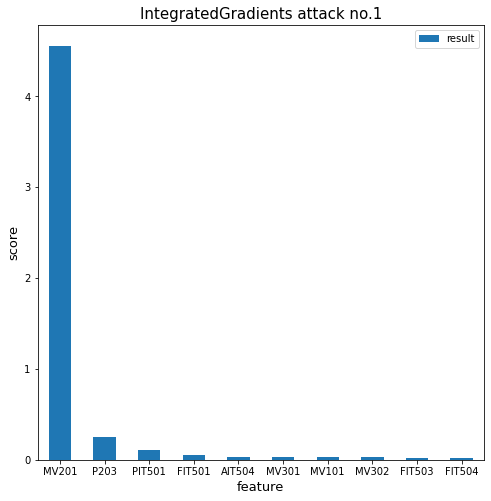

In [87]:
ig_plot = ig_result.sort_values(by = ["result"], ascending=False)[0:10]
ig_plot.plot.bar(rot=0,figsize=(8, 8))
plt.title("IntegratedGradients attack no.1",size=15)
plt.ylabel("score",size=13)
plt.xlabel("feature",size=13)

single value

In [88]:
start = timeit.default_timer()
ig_explanation = ig.explain(sample1.to_numpy(),
                         baselines=None,
                         target=[0]*len(sample1))
end = timeit.default_timer()

In [89]:
print(end-start)

0.21134998600064137


In [ ]:
# type(model).__mro__

###ALE

In [90]:
!pip install alibi[tensorflow] --quiet

In [91]:
from alibi.explainers import ALE

In [92]:
ale = ALE(model.decision_function, feature_names=train_scale.columns)

In [93]:
start = timeit.default_timer()
exp_ale = ale.explain(sample.to_numpy())
end = timeit.default_timer()

In [94]:
print(end-start)

7.213575001999743


In [95]:
exp_ale.feature_names

array(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204',
       'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401',
       'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501',
       'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503',
       'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601',
       'P601', 'P602', 'P603'], dtype=object)

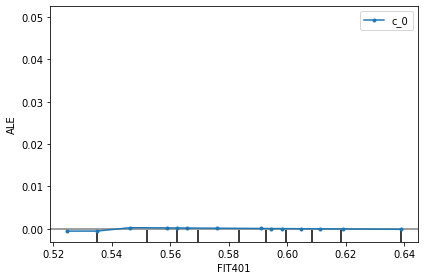

In [96]:
from alibi.explainers import plot_ale
plot_ale(exp_ale, features = ['FIT401']);

In [97]:
mean_ale = []
for e in exp_ale.ale_values:
  mean_ale.append(np.mean(e))

In [98]:
ale_result = pd.DataFrame(mean_ale, index = train_scale.columns, columns = ["result"])

In [99]:
ale_result.sort_values(by=['result'], ascending=False)

result
MV201    1.517831e-03
FIT201   2.151950e-04
PIT503   3.610269e-05
FIT501   2.252374e-05
FIT504   2.123182e-05
LIT101   1.965317e-05
AIT501   5.558351e-06
AIT202   4.672007e-06
AIT503   3.250285e-06
PIT502   2.915830e-06
DPIT301  2.472934e-06
FIT502   1.795239e-06
AIT203   1.494622e-06
UV401    0.000000e+00
P404     0.000000e+00
P403     0.000000e+00
P402     0.000000e+00
AIT401   0.000000e+00
P501     0.000000e+00
P502     0.000000e+00
FIT601   0.000000e+00
P601     0.000000e+00
P602     0.000000e+00
P401     0.000000e+00
P603     0.000000e+00
P302     0.000000e+00
P205     0.000000e+00
MV101    0.000000e+00
P101     0.000000e+00
P102     0.000000e+00
P201     0.000000e+00
P202     0.000000e+00
P203     0.000000e+00
P204     0.000000e+00
P206     0.000000e+00
MV301    0.000000e+00
MV302    0.000000e+00
MV303    0.000000e+00
MV304    0.000000e+00
P301     0.000000e+00
FIT301  -9.179526e-09
AIT502  -5.649205e-07
LIT401  -6.930524e-07
AIT402  -1.663507e-06
LIT301  -3.554144e-06
FIT401  -1.210262e-05
FIT101  -1.794444e-05
AIT201  -4.241858e-05
PIT501  -5.439400e-05
AIT504  -1.609144e-04
FIT503  -2.231110e-04

##CASE STUDY attack no.10
model can detect the anomaly point

###SHAP

In [101]:
sample_9 = shap.sample(test_scale[idx_start[7]:idx_end[7]], 100)

In [102]:
shap_value_9 = shap_explainer.shap_values(X = sample_9, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

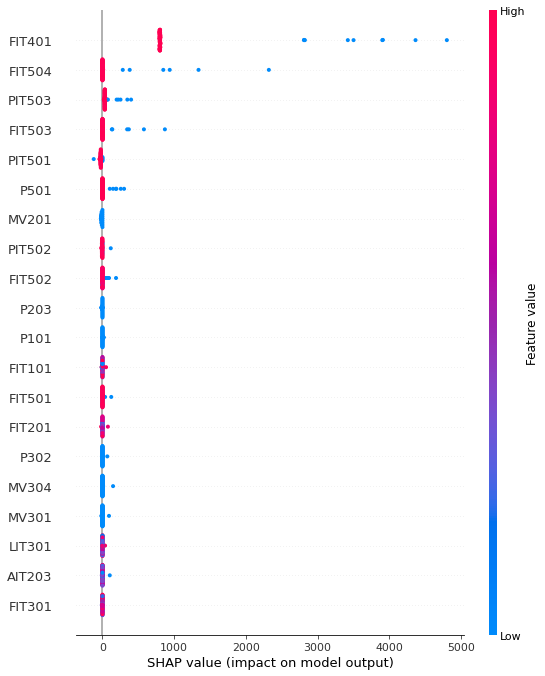

In [103]:
shap.initjs()
shap.summary_plot(shap_value_9, sample_9)

In [104]:
shap_result_9 = pd.DataFrame(np.mean(shap_value_9,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_9.sort_values(by = ["result"])

result
PIT501    -23.413654
MV201      -9.703082
P203       -5.074464
PIT502     -3.613760
FIT101     -2.131306
FIT201     -1.539647
FIT301     -1.311315
AIT503     -1.273361
UV401      -0.958438
LIT301     -0.762227
P302       -0.375089
DPIT301    -0.235213
AIT502     -0.154860
LIT401     -0.123765
P404        0.000000
P402        0.000000
P403        0.000000
P502        0.000000
P601        0.000000
P401        0.000000
P301        0.000000
P603        0.000000
P102        0.000000
P206        0.000000
P204        0.000000
P202        0.000000
P201        0.000000
AIT504      0.050372
P602        0.072786
AIT501      0.101433
MV303       0.157166
AIT401      0.170956
LIT101      0.228517
AIT402      0.319217
MV101       0.353250
AIT201      0.394220
FIT601      0.429981
AIT202      0.532362
MV301       0.671123
AIT203      0.794011
P205        1.014127
MV302       1.310009
MV304       1.417871
FIT501      3.060555
FIT502      3.689181
P101        4.056131
P501       11.859486
FIT503     24.807226
PIT503     45.804160
FIT504     61.646957
FIT401   1052.832036

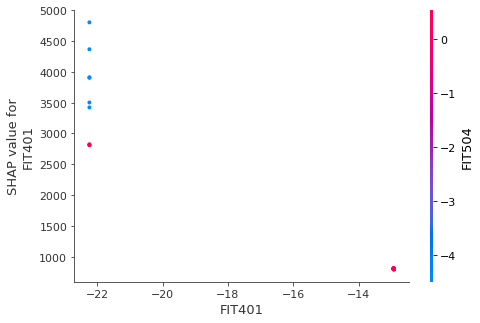

In [105]:
shap.dependence_plot("FIT401", shap_value_9, sample_9)

###LIME

In [106]:
sp_obj_9 = submodular_pick.SubmodularPick(lime, sample_9.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -4.083979578771099
Prediction_local [16.96589007]
Right: 787.7381
Intercept -4.01795008013569
Prediction_local [16.50570072]
Right: 785.184
Intercept -3.9518064829729633
Prediction_local [16.68874663]
Right: 792.75183
Intercept -3.8069069499333397
Prediction_local [16.13088576]
Right: 787.661
Intercept -3.77325284665234
Prediction_local [16.07186271]
Right: 787.0644
Intercept -3.9359932447671455
Prediction_local [16.31627954]
Right: 784.6062
Intercept -3.9311502286097437
Prediction_local [16.59254291]
Right: 785.4312
Intercept -3.893612135930234
Prediction_local [15.80527938]
Right: 796.43933
Intercept -3.907247227760505
Prediction_local [15.82019504]
Right: 789.61304
Intercept -3.865656903925791
Prediction_local [16.36338823]
Right: 785.4312
Intercept -3.9312042328427506
Prediction_local [16.16379574]
Right: 783.36145
Intercept -3.9328347758468167
Prediction_local [16.10072847]
Right: 789.5083
Intercept -4.066375649061338
Prediction_local [16.52897127]
Right: 788.71533
Inter

[<Figure size 432x288 with 1 Axes>]

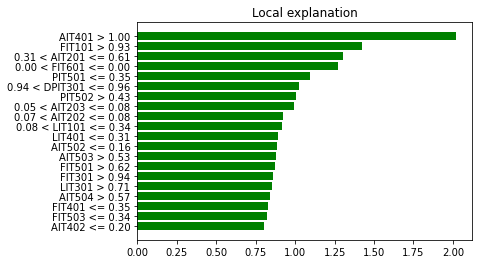

In [107]:
[exp.as_pyplot_figure(label=1) for exp in sp_obj_9.sp_explanations]

In [108]:
sp_obj_9.sp_explanations[0].as_list()

[('AIT401 > 1.00', 2.021789888992039),
 ('FIT101 > 0.93', 1.4263382551301602),
 ('0.31 < AIT201 <= 0.61', 1.3061943315622924),
 ('0.00 < FIT601 <= 0.00', 1.2731730690357463),
 ('PIT501 <= 0.35', 1.0972549738336155),
 ('0.94 < DPIT301 <= 0.96', 1.02166783116772),
 ('PIT502 > 0.43', 1.0054980973014995),
 ('0.05 < AIT203 <= 0.08', 0.9922979979979651),
 ('0.07 < AIT202 <= 0.08', 0.921436150389107),
 ('0.08 < LIT101 <= 0.34', 0.9186421749346487),
 ('LIT401 <= 0.31', 0.8925359689877229),
 ('AIT502 <= 0.16', 0.8843862961257748),
 ('AIT503 > 0.53', 0.8811912082095626),
 ('FIT501 > 0.62', 0.8701928135645516),
 ('FIT301 > 0.94', 0.8620076721705059),
 ('LIT301 > 0.71', 0.8521322381715422),
 ('AIT504 > 0.57', 0.8430580988082584),
 ('FIT401 <= 0.35', 0.8309174375895021),
 ('FIT503 <= 0.34', 0.8215153865806105),
 ('AIT402 <= 0.20', 0.8014632444150711)]

### Intergrate Gredient

In [109]:
ig_explanation_9 = ig.explain(sample_9.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_9))

In [110]:
attributions_9 = ig_explanation_9.attributions

In [111]:
ig_result_9 = pd.DataFrame(np.mean(attributions_9[0],axis=0), index= train_scale.columns, columns = ["result"])

In [112]:
ig_result_9.sort_values(by = ["result"])

result
MV201     -79.682276
P203      -25.827704
FIT201    -17.847708
FIT101    -17.673787
P302      -15.704955
FIT301    -15.222786
AIT503    -14.194551
LIT301     -9.673841
PIT502     -9.269995
UV401      -5.062564
FIT502     -3.748425
AIT501     -2.228544
AIT504     -1.739580
AIT401     -0.829561
AIT402     -0.825367
PIT501     -0.795587
AIT201     -0.587059
DPIT301    -0.517981
AIT202     -0.510664
AIT203     -0.143370
FIT601     -0.032979
LIT401     -0.009171
P404        0.000000
P601        0.000000
P502        0.000000
P102        0.000000
P204        0.000000
P403        0.000000
P402        0.000000
P603        0.000000
P602        0.000000
P301        0.000000
P206        0.000000
P202        0.000000
P401        0.000000
P201        0.000000
AIT502      0.377383
LIT101      0.432959
MV303       2.948407
MV304       3.176424
P205        3.512158
MV301       5.356911
FIT501      9.154696
PIT503     10.950954
MV101      14.086708
P501       16.276422
FIT503     18.281768
P101       24.225174
MV302      37.513020
FIT504     55.040541
FIT401   1183.281148

Text(0.5, 0, 'feature')

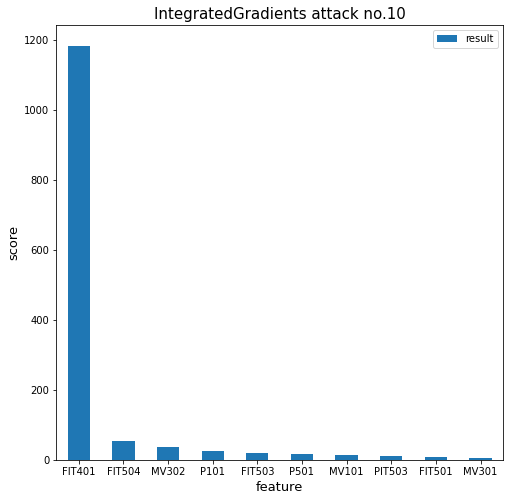

In [113]:
ig_plot_9 = ig_result_9.sort_values(by = ["result"], ascending=False)[0:10]
ig_plot_9.plot.bar(rot=0,figsize=(8, 8))
plt.title("IntegratedGradients attack no.10",size=15)
plt.ylabel("score",size=13)
plt.xlabel("feature",size=13)

###ALE

In [114]:
start = timeit.default_timer()
exp_ale_10 = ale.explain(sample_9.to_numpy())
end = timeit.default_timer()

In [115]:
print(end-start)

5.846953504000339


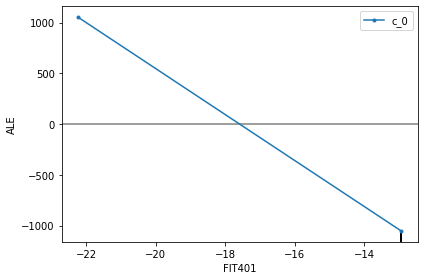

In [117]:
from alibi.explainers import plot_ale
plot_ale(exp_ale_10, features = ['FIT401']);

In [118]:
ale_result_10 = pd.DataFrame([np.mean(e) for e in exp_ale_10.ale_values], index = train_scale.columns, columns = ["result"])

In [123]:
ale_result_10.sort_values(by=['result'], ascending=False)

result
FIT504   155.126949
PIT503    45.919967
FIT503    35.374366
FIT502     7.953158
PIT502     7.560462
FIT501     1.672549
AIT503     0.019125
AIT402     0.011338
AIT502     0.005525
FIT301     0.004630
LIT401     0.003360
LIT101     0.000023
P501       0.000000
P404       0.000000
FIT401     0.000000
P401       0.000000
P402       0.000000
P403       0.000000
UV401      0.000000
P502       0.000000
AIT501     0.000000
P602       0.000000
P601       0.000000
FIT601     0.000000
AIT401     0.000000
P603       0.000000
P302       0.000000
P204       0.000000
MV101      0.000000
P101       0.000000
P102       0.000000
AIT201     0.000000
MV201      0.000000
P201       0.000000
P202       0.000000
P301       0.000000
P203       0.000000
P205       0.000000
P206       0.000000
MV301      0.000000
MV302      0.000000
MV303      0.000000
MV304      0.000000
AIT203    -0.000076
AIT202    -0.000088
DPIT301   -0.000247
LIT301    -0.001978
FIT201    -0.007272
FIT101    -0.021428
AIT504    -0.035102
PIT501    -7.898362

## Attck no. 11


In [124]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 11)].index.values

In [125]:
sample_11 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [126]:
shap_value_11 = shap_explainer.shap_values(X = sample_11, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [127]:
shap_result_11 = pd.DataFrame(np.mean(shap_value_11,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_11.sort_values(by = ["result"])

result
AIT402    -11.102283
P603        0.000000
P601        0.000000
P502        0.000000
P301        0.000000
P102        0.000000
P204        0.000000
P404        0.000000
P403        0.000000
P206        0.000000
P401        0.000000
P201        0.000000
P202        0.000000
P402        1.434674
AIT504      1.784181
UV401       5.663855
DPIT301     7.430459
FIT101      8.588717
P203        9.101063
FIT201      9.151212
AIT501      9.601575
FIT601     10.010033
AIT401     10.895521
LIT101     11.165596
P101       12.333641
MV101      12.871725
AIT203     13.292272
MV201      14.379943
P302       14.614417
MV303      16.039410
PIT502     16.528393
LIT301     16.626173
P602       16.808189
AIT201     16.905325
MV301      18.782551
AIT503     19.073497
LIT401     19.255550
AIT202     20.019304
MV302      20.079460
P205       20.894829
FIT301     24.832966
MV304      25.796926
AIT502     26.266085
PIT501     58.953232
FIT502     81.324850
FIT501    139.139635
P501      235.792694
PIT503    484.181885
FIT503   1121.664678
FIT504   3058.837149
FIT401   4501.886317

In [129]:
sp_obj_11 = submodular_pick.SubmodularPick(lime, sample_11.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -59.426406230723956
Prediction_local [213.31695755]
Right: 10878.596
Intercept -25.084245335199103
Prediction_local [138.13038267]
Right: 4312.1484
Intercept -56.504180640525405
Prediction_local [210.65443723]
Right: 10472.699
Intercept -57.06744370649223
Prediction_local [212.43766048]
Right: 10446.402
Intercept -55.626235519961426
Prediction_local [204.98042294]
Right: 10447.113
Intercept -60.24518076755912
Prediction_local [222.47801555]
Right: 10407.334
Intercept -58.16423145542562
Prediction_local [205.59886557]
Right: 10409.758
Intercept -58.33329245144317
Prediction_local [213.33725198]
Right: 10390.455
Intercept -56.915675195588115
Prediction_local [201.92438492]
Right: 10387.255
Intercept -1.3775902348643587
Prediction_local [7.31808181]
Right: 237.03226
Intercept -55.78143844491199
Prediction_local [197.24609692]
Right: 10449.291
Intercept -59.15744471543002
Prediction_local [207.74357802]
Right: 10804.278
Intercept -58.36300269847995
Prediction_local [205.93960967]

In [130]:
sp_obj_11.sp_explanations[0].as_list()

[('AIT401 > 1.00', 26.447073899634994),
 ('FIT101 > 0.93', 19.22705395374628),
 ('0.31 < AIT201 <= 0.61', 16.15205362725997),
 ('0.00 < FIT601 <= 0.00', 15.825473822337031),
 ('FIT504 <= 0.43', 13.348970373539288),
 ('AIT503 > 0.53', 12.929535686241387),
 ('FIT503 <= 0.34', 12.92304527941483),
 ('PIT501 <= 0.35', 12.804659246241332),
 ('0.08 < LIT101 <= 0.34', 12.318293711939726),
 ('0.05 < AIT203 <= 0.08', 12.125682633801091),
 ('FIT301 > 0.94', 12.11322833634592),
 ('0.94 < DPIT301 <= 0.96', 12.070089250714798),
 ('PIT502 <= 0.30', 11.976521076517766),
 ('AIT402 > 0.78', 11.959569273025158),
 ('AIT504 > 0.57', 11.908563145701644),
 ('0.08 < AIT202 <= 0.16', 11.814574605730444),
 ('0.01 < FIT201 <= 0.98', 11.75948343140656),
 ('LIT401 <= 0.31', 11.653917824493279),
 ('FIT401 <= 0.35', 11.014649670520788),
 ('FIT502 <= 0.41', 10.575489599753134)]

In [131]:
ig_explanation_11 = ig.explain(sample_11.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_11))

In [132]:
attributions_11 = ig_explanation_11.attributions

In [133]:
ig_result_11 = pd.DataFrame(np.mean(attributions_11[0],axis=0), index= train_scale.columns, columns = ["result"])

In [134]:
ig_result_11.sort_values(by = ["result"])

result
P101     -196.819314
AIT402   -159.302196
FIT301   -141.452615
PIT501   -122.055713
AIT504    -85.305916
MV201     -78.202546
FIT501    -68.719897
UV401     -62.125253
FIT101    -53.519900
FIT201    -48.465597
P302      -45.966038
AIT503    -43.423090
AIT501    -42.622733
AIT401    -20.142481
MV304     -19.893552
MV301     -19.794265
P205       -7.793129
FIT601     -5.850274
MV303      -4.862974
LIT101     -3.914713
P602       -3.679292
AIT202     -3.103177
AIT203     -1.977734
P601        0.000000
P502        0.000000
P102        0.000000
P204        0.000000
P403        0.000000
P401        0.000000
P404        0.000000
P603        0.000000
P206        0.000000
P201        0.000000
P202        0.000000
P301        0.000000
AIT201      0.520468
LIT401      1.773316
P402        2.826348
LIT301      6.126856
AIT502     10.298543
P203       10.595937
PIT502     14.487842
MV101      48.389798
DPIT301    60.320487
MV302      72.326690
FIT502    150.486101
P501      371.500577
PIT503    607.004584
FIT503   1016.921095
FIT504   3172.359466
FIT401   5791.343850

In [135]:
exp_ale_11 = ale.explain(sample_11.to_numpy())

In [136]:
ale_result_11 = pd.DataFrame([np.mean(e) for e in exp_ale_11.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_11.sort_values(by=['result'], ascending=False)

result
FIT301      4.999540
PIT501      3.049157
AIT402      2.657683
FIT201      1.829307
FIT501      1.464631
AIT501      0.428007
AIT203      0.078678
LIT301      0.023745
FIT101      0.022384
P501        0.000000
MV304       0.000000
UV401       0.000000
P404        0.000000
P403        0.000000
P402        0.000000
P401        0.000000
P502        0.000000
P601        0.000000
P602        0.000000
P302        0.000000
P301        0.000000
P603        0.000000
MV303       0.000000
MV302       0.000000
MV101       0.000000
P101        0.000000
P102        0.000000
P206        0.000000
P205        0.000000
P204        0.000000
P203        0.000000
P202        0.000000
P201        0.000000
MV201       0.000000
AIT201     -0.002012
LIT401     -0.002273
AIT401     -0.002871
LIT101     -0.016202
AIT502     -0.017162
AIT202     -0.072897
AIT503     -0.386601
DPIT301    -1.967294
AIT504     -3.183003
FIT502     -5.038802
PIT502     -8.367820
MV301     -19.294904
PIT503    -19.370502
FIT503    -59.566389
FIT601    -88.180276
FIT504   -480.838627
FIT401  -1753.292925

## Attck no. 20


In [137]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 20)].index.values

In [138]:
sample_20 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [139]:
shap_value_20 = shap_explainer.shap_values(X = sample_20, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [140]:
shap_result_20 = pd.DataFrame(np.mean(shap_value_20,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_20.sort_values(by = ["result"])

result
PIT501    -19.157880
FIT401    -13.929562
P101       -7.189904
FIT101     -2.707811
P302       -2.540668
MV201      -2.521221
FIT503     -1.068703
PIT502     -1.002980
AIT201     -0.618891
P203       -0.525368
FIT502     -0.504167
AIT502     -0.402278
AIT401     -0.386162
FIT301     -0.288330
AIT501     -0.288236
LIT301     -0.280284
P602       -0.153732
MV301      -0.072897
AIT202     -0.072253
MV304      -0.035913
P204        0.000000
P601        0.000000
P502        0.000000
P501        0.000000
P102        0.000000
UV401       0.000000
P404        0.000000
P202        0.000000
P402        0.000000
P403        0.000000
P603        0.000000
P206        0.000000
P201        0.000000
P301        0.000000
P401        0.000000
AIT203      0.071712
LIT101      0.078248
MV303       0.123281
LIT401      0.166409
MV302       0.246391
DPIT301     0.423420
FIT504      0.443098
AIT402      0.563706
MV101       0.631383
FIT601      1.000398
AIT503      2.475693
P205        2.547300
FIT501      6.539874
FIT201      9.355106
PIT503     23.212454
AIT504   2239.142729

In [141]:
sp_obj_20 = submodular_pick.SubmodularPick(lime, sample_20.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -11.615057613357553
Prediction_local [43.23415073]
Right: 2224.0156
Intercept -11.892688583906569
Prediction_local [42.1729715]
Right: 2230.6987
Intercept -11.8390080345914
Prediction_local [42.32782431]
Right: 2224.4006
Intercept -12.280553592548525
Prediction_local [44.7323165]
Right: 2236.6362
Intercept -11.654183026598682
Prediction_local [42.26005697]
Right: 2238.2197
Intercept -11.947457424898767
Prediction_local [43.97877364]
Right: 2234.831
Intercept -11.738605797633758
Prediction_local [43.59623038]
Right: 2241.9277
Intercept -12.31423453163915
Prediction_local [44.692677]
Right: 2227.6611
Intercept -12.2999361981933
Prediction_local [43.77097693]
Right: 2228.3682
Intercept -12.095289618930893
Prediction_local [43.85406656]
Right: 2235.106
Intercept -12.15749193162212
Prediction_local [45.28890658]
Right: 2236.375
Intercept -11.880834157677178
Prediction_local [42.58122744]
Right: 2236.3652
Intercept -11.754379671133536
Prediction_local [42.49573764]
Right: 2233.471


In [142]:
sp_obj_20.sp_explanations[0].as_list()

[('AIT401 > 1.00', 5.684563790396701),
 ('0.00 < FIT601 <= 0.00', 3.251823957969762),
 ('0.31 < LIT401 <= 0.52', 3.1430634474535357),
 ('0.54 < LIT301 <= 0.71', 3.1425953692087885),
 ('0.08 < AIT202 <= 0.16', 2.8681764008144706),
 ('0.94 < FIT301 <= 0.94', 2.7987571688371973),
 ('PIT501 <= 0.35', 2.786476186027936),
 ('FIT504 <= 0.43', 2.7085978693756263),
 ('PIT502 > 0.43', 2.70479372974034),
 ('0.94 < DPIT301 <= 0.96', 2.699109444097867),
 ('0.00 < FIT101 <= 0.92', 2.67013066388857),
 ('FIT501 > 0.62', 2.6507958185635547),
 ('0.08 < AIT203 <= 0.10', 2.6475882103227164),
 ('AIT503 <= 0.42', 2.611526291078371),
 ('AIT504 > 0.57', 2.588310791533045),
 ('AIT502 <= 0.16', 2.509993625551073),
 ('FIT503 <= 0.34', 2.4705355169416325),
 ('LIT101 <= 0.08', 2.4355808687410203),
 ('FIT401 > 0.63', 2.414963213835724),
 ('FIT201 > 0.98', 2.3126022285689256)]

In [143]:
ig_explanation_20 = ig.explain(sample_20.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_20))

In [144]:
attributions_20 = ig_explanation_20.attributions

In [145]:
ig_result_20 = pd.DataFrame(np.mean(attributions_20[0],axis=0), index= train_scale.columns, columns = ["result"])

In [146]:
ig_result_20.sort_values(by = ["result"])

result
FIT401    -55.518873
P101      -32.802762
MV201     -30.518429
PIT503    -28.382903
P302      -22.305692
FIT101    -16.211415
AIT401     -9.766770
MV303      -9.154061
AIT503     -6.782500
FIT502     -6.018925
P203       -5.942035
FIT301     -5.328771
LIT301     -4.891356
PIT502     -3.664022
FIT504     -3.202630
AIT202     -0.656714
AIT203     -0.603612
AIT201     -0.180924
LIT101     -0.138058
FIT601     -0.044428
AIT402     -0.040826
P502        0.000000
P401        0.000000
P601        0.000000
UV401       0.000000
P404        0.000000
P403        0.000000
P402        0.000000
P501        0.000000
P603        0.000000
P602        0.000000
P102        0.000000
P301        0.000000
P201        0.000000
P202        0.000000
P204        0.000000
P206        0.000000
AIT501      0.045397
AIT502      0.269394
LIT401      1.854669
MV301       4.082134
FIT503      4.374283
MV304       5.431644
MV302      10.350184
MV101      11.083925
DPIT301    12.490528
P205       13.783896
FIT501     30.648398
PIT501     32.767712
FIT201     39.371029
AIT504   2306.259672

In [147]:
exp_ale_20 = ale.explain(sample_20.to_numpy())
ale_result_20 = pd.DataFrame([np.mean(e) for e in exp_ale_20.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_20.sort_values(by=['result'], ascending=False)

result
FIT501   0.243685
PIT501   0.164082
FIT503   0.108243
PIT502   0.044618
AIT201   0.014057
FIT201   0.006072
DPIT301  0.005087
AIT502   0.004154
AIT202   0.002020
LIT401   0.001692
AIT203   0.000152
P401     0.000000
P402     0.000000
P403     0.000000
P404     0.000000
UV401    0.000000
AIT401   0.000000
AIT504   0.000000
P302     0.000000
P502     0.000000
FIT601   0.000000
P601     0.000000
P602     0.000000
P501     0.000000
P603     0.000000
P205     0.000000
P204     0.000000
MV101    0.000000
P301     0.000000
MV304    0.000000
MV303    0.000000
MV302    0.000000
MV301    0.000000
P101     0.000000
P102     0.000000
MV201    0.000000
P201     0.000000
P206     0.000000
P202     0.000000
P203     0.000000
LIT101  -0.000202
AIT501  -0.000593
FIT301  -0.000935
LIT301  -0.006770
AIT402  -0.008885
FIT101  -0.011753
FIT401  -0.028744
FIT504  -0.071772
FIT502  -0.082515
PIT503  -0.218801
AIT503  -0.559957

## Attck no. 22


In [148]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 22)].index.values

In [149]:
sample_22 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [150]:
shap_value_22 = shap_explainer.shap_values(X = sample_22, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [151]:
shap_result_22 = pd.DataFrame(np.mean(shap_value_22,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_22.sort_values(by = ["result"])

result
PIT503    -57.216234
AIT402    -16.306490
AIT504    -11.598327
P101       -0.542741
P603        0.000000
P301        0.000000
P403        0.000000
P404        0.000000
P206        0.000000
P402        0.000000
P204        0.000000
P502        0.000000
P201        0.000000
P102        0.000000
P202        0.000000
P601        0.000000
P401        0.000000
AIT501      0.579088
FIT301      1.039644
P602        1.419522
FIT601      2.951368
UV401       4.126504
MV101       4.461373
AIT201      4.572319
MV201       5.595441
FIT201      5.631679
AIT503      6.052463
P302        6.169033
LIT101      6.275534
AIT401      6.303190
AIT502      6.467994
P205        7.489835
FIT101      7.597718
LIT401      8.465668
MV301       9.254770
DPIT301     9.321001
AIT203      9.464979
LIT301      9.755032
PIT502     10.884083
MV302      12.467955
MV304      13.451536
P203       13.601164
AIT202     13.912333
MV303      16.892684
FIT502     52.310995
P501       94.976794
FIT401    337.201581
FIT501    476.430047
PIT501    525.284311
FIT503   1114.997194
FIT504   1907.598533

In [152]:
sp_obj_22 = submodular_pick.SubmodularPick(lime, sample_22.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -24.427397034845438
Prediction_local [78.46351889]
Right: 4630.395
Intercept -24.448410455545243
Prediction_local [79.27378363]
Right: 4606.3477
Intercept -24.741106250918502
Prediction_local [78.46560762]
Right: 4591.0576
Intercept -25.341595088880673
Prediction_local [79.96645946]
Right: 4606.953
Intercept -24.711371757402052
Prediction_local [78.75070397]
Right: 4617.051
Intercept -24.957900152953474
Prediction_local [78.79478099]
Right: 4593.747
Intercept -25.016694465681688
Prediction_local [80.01755628]
Right: 4619.1094
Intercept -24.3188063568607
Prediction_local [77.71477629]
Right: 4600.873
Intercept -25.750223546267936
Prediction_local [81.85699876]
Right: 4781.4824
Intercept -25.01530858748956
Prediction_local [79.04662607]
Right: 4600.002
Intercept -24.743660554971182
Prediction_local [77.81838671]
Right: 4619.1094
Intercept -25.112501508827044
Prediction_local [78.37648814]
Right: 4739.758
Intercept -25.553978430038384
Prediction_local [80.26879915]
Right: 4596.1

In [153]:
sp_obj_22.sp_explanations[0].as_list()

[('0.08 < AIT203 <= 0.10', 5.52919407343529),
 ('FIT501 <= 0.32', 5.459916680068893),
 ('AIT402 > 0.78', 5.455453448088851),
 ('FIT401 <= 0.35', 5.36904068908394),
 ('FIT504 <= 0.43', 5.312378693325563),
 ('0.31 < LIT401 <= 0.52', 5.298943289111225),
 ('0.16 < AIT502 <= 0.50', 5.274401245637322),
 ('FIT502 <= 0.41', 5.226314644632082),
 ('FIT503 <= 0.34', 5.152405436298802),
 ('AIT504 > 0.57', 5.149402748663571),
 ('0.12 < FIT301 <= 0.94', 5.1421729148286985),
 ('PIT501 <= 0.35', 5.044902132076433),
 ('0.34 < LIT101 <= 0.64', 5.024746620011684),
 ('AIT202 > 0.16', 4.994085681100003),
 ('FIT201 > 0.98', 4.976818982390898),
 ('AIT503 <= 0.42', 4.968187589710715),
 ('LIT301 <= 0.36', 4.867242725210121),
 ('PIT503 <= 0.34', 4.849351222620033),
 ('DPIT301 > 0.96', 4.818116033760955),
 ('PIT502 <= 0.30', 4.648972419706817)]

In [154]:
ig_explanation_22 = ig.explain(sample_22.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_22))

In [155]:
attributions_22 = ig_explanation_22.attributions

In [156]:
ig_result_22 = pd.DataFrame(np.mean(attributions_22[0],axis=0), index= train_scale.columns, columns = ["result"])

In [157]:
ig_result_22.sort_values(by = ["result"])

result
PIT503   -121.136998
P101     -106.804531
FIT201   -103.169954
FIT301   -100.655074
AIT504    -96.940307
AIT402    -91.858684
AIT501    -48.277838
UV401     -43.506337
MV201     -39.288445
MV304     -22.544755
AIT401    -18.197718
AIT503    -16.455480
P205      -13.044946
AIT201     -8.339492
LIT101     -6.935102
AIT202     -2.352634
AIT203     -2.241314
AIT502     -0.741126
MV301      -0.171143
P502        0.000000
P601        0.000000
FIT601      0.000000
P404        0.000000
P403        0.000000
P402        0.000000
P401        0.000000
FIT101      0.000000
P603        0.000000
P202        0.000000
P102        0.000000
P602        0.000000
P201        0.000000
P206        0.000000
P204        0.000000
P301        0.000000
LIT301      0.349623
P302        0.603336
LIT401      3.681121
MV101       6.046244
PIT502      6.779348
MV303       7.781653
DPIT301    27.828301
MV302      45.730322
P203       76.074598
FIT502     99.439151
P501      129.918633
FIT401    523.445213
FIT501    535.110639
PIT501    661.842112
FIT503   1196.098349
FIT504   2146.656005

In [158]:
exp_ale_22 = ale.explain(sample_22.to_numpy())
ale_result_22 = pd.DataFrame([np.mean(e) for e in exp_ale_22.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_22.sort_values(by=['result'], ascending=False)

result
PIT503    4.396660
AIT501    0.686879
AIT402    0.656826
AIT201    0.096834
LIT401    0.016601
LIT301    0.003772
DPIT301   0.002666
UV401     0.000000
P401      0.000000
P402      0.000000
P403      0.000000
P404      0.000000
FIT101    0.000000
P301      0.000000
FIT504    0.000000
P501      0.000000
P502      0.000000
PIT502    0.000000
FIT601    0.000000
P601      0.000000
P602      0.000000
P302      0.000000
AIT401    0.000000
MV304     0.000000
P203      0.000000
MV101     0.000000
P101      0.000000
P102      0.000000
MV201     0.000000
P201      0.000000
MV303     0.000000
P202      0.000000
P603      0.000000
P204      0.000000
P206      0.000000
MV302     0.000000
P205      0.000000
MV301     0.000000
AIT202   -0.014138
FIT301   -0.016294
AIT203   -0.019146
FIT201   -0.025822
LIT101   -0.042012
AIT503   -0.186054
AIT502   -2.479536
AIT504   -3.480893
FIT502   -4.033429
FIT401  -12.340516
FIT501  -25.127834
PIT501  -40.414934
FIT503  -53.525228

## Attck no. 28


In [159]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 28)].index.values

In [160]:
sample_28 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [161]:
shap_value_28 = shap_explainer.shap_values(X = sample_28, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [162]:
shap_result_28 = pd.DataFrame(np.mean(shap_value_28,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_28.sort_values(by = ["result"])

result
PIT503    -35.257352
AIT402     -6.062159
P603        0.000000
P301        0.000000
P206        0.000000
P401        0.000000
P204        0.000000
P202        0.000000
P201        0.000000
P404        0.000000
P502        0.000000
P102        0.000000
P601        0.000000
P403        0.000000
LIT401     10.699225
P203       14.817627
MV303      18.251912
AIT504     18.260922
MV304      18.696410
P602       18.945707
P402       20.808055
LIT101     21.257917
FIT101     21.416485
DPIT301    24.414361
AIT503     25.146112
LIT301     26.220037
MV301      27.844153
AIT202     28.250129
PIT502     30.457978
FIT601     31.815494
MV201      32.080318
AIT502     34.985794
AIT203     37.383314
MV101      37.587358
P205       38.792310
AIT201     39.180215
AIT401     41.961580
P302       45.436486
MV302      46.401358
UV401      48.253074
AIT501     69.152563
FIT201     76.006410
FIT301     79.847900
P101       94.758667
P501      176.285487
FIT502    620.360915
PIT501   3226.062845
FIT501   4000.148393
FIT401   4020.744924
FIT504   4600.307108
FIT503   5178.971900

In [163]:
sp_obj_28 = submodular_pick.SubmodularPick(lime, sample_28.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -129.70077825919532
Prediction_local [546.85656074]
Right: 22770.615
Intercept -130.92572637790755
Prediction_local [528.40003269]
Right: 22796.438
Intercept -134.18732669166073
Prediction_local [564.06038836]
Right: 22847.664
Intercept -133.4325902563926
Prediction_local [561.27979363]
Right: 22867.074
Intercept -135.01062520905728
Prediction_local [541.13369704]
Right: 22943.121
Intercept -132.9970521746421
Prediction_local [576.11237423]
Right: 22886.457
Intercept -125.72105016878346
Prediction_local [559.70612145]
Right: 22805.068
Intercept -132.28602276608322
Prediction_local [567.76810906]
Right: 22891.027
Intercept -129.8277791956889
Prediction_local [579.93896798]
Right: 22786.037
Intercept -126.58691202411549
Prediction_local [550.85367779]
Right: 22933.852
Intercept -133.04294425342684
Prediction_local [564.41364574]
Right: 22886.799
Intercept -129.48183214049922
Prediction_local [554.13325484]
Right: 22779.008
Intercept -130.49605403103135
Prediction_local [566.037

In [164]:
sp_obj_28.sp_explanations[0].as_list()

[('MV304 > 0.50', 173.34231769425693),
 ('AIT401 > 1.00', 59.16475382452606),
 ('0.49 < AIT503 <= 0.53', 30.26621898512673),
 ('PIT501 <= 0.35', 29.85659460850125),
 ('AIT504 > 0.57', 29.844773588399867),
 ('AIT402 > 0.78', 28.90603396270349),
 ('PIT502 <= 0.30', 27.72078759066686),
 ('FIT502 <= 0.41', 27.666263836107504),
 ('FIT201 <= 0.01', 27.49185799682279),
 ('LIT301 > 0.71', 27.18167629029901),
 ('FIT504 <= 0.43', 27.162658443133857),
 ('FIT301 <= 0.12', 26.641631062650625),
 ('LIT101 > 0.64', 26.594392047912677),
 ('FIT503 <= 0.34', 26.48992691429605),
 ('AIT202 > 0.16', 26.28157609140198),
 ('FIT501 <= 0.32', 26.253671147644454),
 ('AIT502 > 0.78', 26.038038295593655),
 ('PIT503 <= 0.34', 25.808133677067108),
 ('DPIT301 <= 0.12', 25.787864716630814),
 ('FIT401 <= 0.35', 25.298533481021927)]

In [165]:
ig_explanation_28 = ig.explain(sample_28.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_28))

In [166]:
attributions_28 = ig_explanation_28.attributions

In [167]:
ig_result_28 = pd.DataFrame(np.mean(attributions_28[0],axis=0), index= train_scale.columns, columns = ["result"])

In [168]:
ig_result_28.sort_values(by = ["result"])

result
AIT402   -539.041544
PIT503   -531.926292
AIT504   -235.307272
UV401    -113.387825
MV304    -110.743573
LIT401    -97.062470
P402      -82.661249
LIT101    -58.530462
AIT502    -51.740828
AIT401    -48.719980
AIT503    -42.940223
MV201     -40.756764
MV301     -22.263603
AIT202    -21.092818
AIT203     -8.394077
MV101      -5.057280
FIT601     -0.005839
FIT301     -0.000988
P502        0.000000
P404        0.000000
P403        0.000000
P401        0.000000
P601        0.000000
P602        0.000000
FIT101      0.000000
P301        0.000000
P101        0.000000
P102        0.000000
FIT201      0.000000
P302        0.000000
P202        0.000000
P203        0.000000
P204        0.000000
P201        0.000000
P603        0.000000
P206        0.000000
P205        0.000000
DPIT301     2.618265
LIT301      5.826223
MV303       9.898964
PIT502     24.416467
MV302      40.605636
AIT201     53.408803
AIT501    111.669549
P501      303.743935
FIT502    775.635475
PIT501   4042.430607
FIT504   4403.328970
FIT501   4603.973285
FIT401   5019.319299
FIT503   5470.833634

In [169]:
exp_ale_28 = ale.explain(sample_28.to_numpy())
ale_result_28 = pd.DataFrame([np.mean(e) for e in exp_ale_28.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_28.sort_values(by=['result'], ascending=False)

result
AIT402   15.551627
AIT504    2.155814
FIT503    1.389392
AIT502    0.175862
AIT203    0.116053
PIT503    0.077100
LIT401    0.008740
UV401     0.000000
FIT401    0.000000
P401      0.000000
P402      0.000000
P403      0.000000
P404      0.000000
FIT101    0.000000
P301      0.000000
FIT504    0.000000
P501      0.000000
P502      0.000000
PIT502    0.000000
P601      0.000000
P602      0.000000
P302      0.000000
P603      0.000000
MV304     0.000000
P204      0.000000
MV101     0.000000
P101      0.000000
P102      0.000000
FIT201    0.000000
MV201     0.000000
P201      0.000000
MV303     0.000000
P203      0.000000
P202      0.000000
P205      0.000000
MV302     0.000000
P206      0.000000
MV301     0.000000
LIT301   -0.000787
AIT401   -0.001541
AIT202   -0.005701
LIT101   -0.009224
DPIT301  -0.017402
FIT301   -0.022830
FIT502   -0.025292
FIT601   -0.083029
AIT503   -0.101386
AIT201   -0.193223
PIT501   -0.249985
FIT501   -0.736853
AIT501   -1.888403

## Attck no. 30

In [170]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 30)].index.values

In [171]:
sample_30 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [172]:
shap_value_30 = shap_explainer.shap_values(X = sample_30, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [173]:
shap_result_30 = pd.DataFrame(np.mean(shap_value_30,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_30.sort_values(by = ["result"])

result
PIT501   -1.380333
P101     -0.281114
DPIT301  -0.040039
FIT503   -0.018173
AIT501   -0.009335
P203     -0.007299
MV101    -0.001463
FIT504   -0.001453
P302     -0.001055
LIT101   -0.000606
P603      0.000000
P402      0.000000
P301      0.000000
P403      0.000000
P404      0.000000
UV401     0.000000
P204      0.000000
P401      0.000000
P202      0.000000
P201      0.000000
P501      0.000000
P502      0.000000
P601      0.000000
P206      0.000000
FIT401    0.000699
AIT202    0.001392
AIT503    0.003674
MV303     0.005491
AIT401    0.005590
P602      0.007306
AIT203    0.007904
PIT502    0.008850
FIT502    0.009374
LIT401    0.011431
FIT101    0.011870
AIT402    0.011966
FIT601    0.013110
P205      0.014520
MV301     0.015557
MV304     0.015932
LIT301    0.035394
MV302     0.043729
MV201     0.046767
FIT301    0.064158
FIT501    0.093837
AIT502    0.110612
FIT201    0.934003
AIT504    1.014798
PIT503    1.110303
AIT201    4.870467
P102     18.592595

In [174]:
sp_obj_30 = submodular_pick.SubmodularPick(lime, sample_30.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept 0.9893274845930259
Prediction_local [12.84211304]
Right: 25.29845
Intercept 1.169274575415728
Prediction_local [12.73451452]
Right: 25.148886
Intercept 1.1512260034447306
Prediction_local [12.88202758]
Right: 25.260597
Intercept 1.1701112558371274
Prediction_local [12.82742496]
Right: 25.147251
Intercept 1.076161553276851
Prediction_local [12.76616739]
Right: 25.197222
Intercept 0.9910596900560896
Prediction_local [12.92062802]
Right: 25.35231
Intercept 1.2106815247508993
Prediction_local [12.72040219]
Right: 25.011644
Intercept 1.2083193188138661
Prediction_local [12.8983266]
Right: 25.539612
Intercept 1.0354396202504903
Prediction_local [12.91489045]
Right: 25.464247
Intercept 1.0960206981711846
Prediction_local [12.99302363]
Right: 25.433651
Intercept 1.271745155527022
Prediction_local [13.08704223]
Right: 25.68725
Intercept 1.226439260731358
Prediction_local [12.91512773]
Right: 25.401604
Intercept 1.2569781473967003
Prediction_local [13.06896253]
Right: 25.646599
Interce

In [175]:
sp_obj_30.sp_explanations[0].as_list()

[('P102 > 0.00', 12.615221610069412),
 ('0.00 < P101 <= 1.00', -0.4691508336064704),
 ('P602 <= 0.00', -0.33242042791419535),
 ('PIT501 <= 0.35', 0.31129374858957615),
 ('0.50 < MV201 <= 1.00', -0.3101474124613719),
 ('0.50 < MV302 <= 1.00', -0.22290796820739808),
 ('0.00 < P203 <= 1.00', 0.12433186785374913),
 ('FIT201 > 0.98', -0.11720458931512308),
 ('MV304 <= 0.50', 0.10643751397113112),
 ('PIT503 <= 0.34', -0.10191448233493754),
 ('MV303 <= 0.50', 0.09103243760777421),
 ('DPIT301 > 0.96', 0.07199528000998093),
 ('AIT504 > 0.57', -0.051338625803149754),
 ('AIT203 <= 0.05', -0.050393918440934146),
 ('FIT503 <= 0.34', 0.04618347782855354),
 ('MV101 <= 0.50', 0.045434476283477174),
 ('MV301 <= 0.50', 0.04404019717975414),
 ('0.00 < P302 <= 1.00', 0.03911001207806611),
 ('LIT101 > 0.64', -0.028126059752176295),
 ('AIT201 <= 0.31', -0.025960405683906677)]

In [176]:
ig_explanation_30 = ig.explain(sample_30.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_30))

In [177]:
attributions_30 = ig_explanation_30.attributions

In [178]:
ig_result_30 = pd.DataFrame(np.mean(attributions_30[0],axis=0), index= train_scale.columns, columns = ["result"])

In [179]:
ig_result_30.sort_values(by = ["result"])

result
P101     -2.597420
DPIT301  -0.926661
MV201    -0.885925
PIT503   -0.761057
FIT401   -0.631981
P203     -0.236542
LIT101   -0.225475
LIT301   -0.160443
MV303    -0.096687
MV301    -0.088926
LIT401   -0.081519
AIT202   -0.073212
PIT502   -0.070898
P302     -0.060996
MV101    -0.051193
AIT203   -0.007826
P401      0.000000
P402      0.000000
P404      0.000000
FIT601    0.000000
UV401     0.000000
P501      0.000000
P502      0.000000
P601      0.000000
P403      0.000000
FIT101    0.000000
P603      0.000000
P602      0.000000
P301      0.000000
P201      0.000000
P202      0.000000
P204      0.000000
P206      0.000000
P205      0.046779
AIT501    0.049450
AIT402    0.051936
AIT502    0.059845
FIT502    0.062886
AIT503    0.109770
FIT503    0.173898
AIT401    0.223511
FIT504    0.249941
MV304     0.283866
FIT301    0.666577
FIT501    1.021176
MV302     1.269982
PIT501    1.306806
AIT504    1.373100
FIT201    3.407709
AIT201    5.483322
P102     13.819840

In [180]:
exp_ale_30 = ale.explain(sample_30.to_numpy())
ale_result_30 = pd.DataFrame([np.mean(e) for e in exp_ale_30.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_30.sort_values(by=['result'], ascending=False)

result
FIT503   0.025872
FIT504   0.022085
PIT501   0.011117
AIT201   0.006250
AIT501   0.002007
FIT501   0.001917
FIT201   0.001793
FIT301   0.000023
AIT401   0.000010
P501     0.000000
P502     0.000000
P301     0.000000
FIT601   0.000000
P601     0.000000
UV401    0.000000
P404     0.000000
P403     0.000000
P602     0.000000
P402     0.000000
P401     0.000000
LIT101   0.000000
P302     0.000000
FIT101   0.000000
MV304    0.000000
P204     0.000000
MV101    0.000000
P101     0.000000
P102     0.000000
MV201    0.000000
P201     0.000000
P202     0.000000
P203     0.000000
MV303    0.000000
P603     0.000000
P205     0.000000
P206     0.000000
MV302    0.000000
MV301    0.000000
AIT502  -0.000076
DPIT301 -0.000119
AIT202  -0.000286
FIT502  -0.000292
AIT402  -0.000350
AIT503  -0.000358
AIT203  -0.000567
LIT401  -0.000842
LIT301  -0.000905
FIT401  -0.001310
AIT504  -0.002321
PIT503  -0.006184
PIT502  -0.008763

## Attck no. 34

In [181]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 34)].index.values

In [182]:
sample_34 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [183]:
shap_value_34 = shap_explainer.shap_values(X = sample_34, nsamples = 100)

  0%|          | 0/69 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [184]:
shap_result_34 = pd.DataFrame(np.mean(shap_value_34,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_34.sort_values(by = ["result"])

result
PIT501   -1.137298
DPIT301  -0.177450
FIT401   -0.012921
P203     -0.012054
AIT501   -0.003005
P603      0.000000
P401      0.000000
P402      0.000000
P403      0.000000
P404      0.000000
P206      0.000000
P204      0.000000
P202      0.000000
UV401     0.000000
P501      0.000000
P502      0.000000
P601      0.000000
P201      0.000000
P301      0.000000
FIT504    0.002142
FIT503    0.002465
MV101     0.004418
P205      0.005428
MV301     0.005838
AIT401    0.005939
AIT203    0.006896
AIT202    0.007975
FIT101    0.008453
FIT601    0.014101
P302      0.015443
MV303     0.016827
LIT401    0.020010
P602      0.020176
AIT503    0.022720
AIT402    0.023106
MV304     0.024042
LIT101    0.025916
FIT502    0.027283
FIT201    0.037850
MV201     0.040066
FIT501    0.041927
PIT502    0.045657
LIT301    0.073636
FIT301    0.083645
MV302     0.132213
AIT502    0.136735
P101      0.797931
AIT504    1.126409
PIT503    1.191167
AIT201    5.049085
P102     17.789491

In [185]:
sp_obj_34 = submodular_pick.SubmodularPick(lime, sample_34.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept 1.2354069544553554
Prediction_local [0.32831247]
Right: 1.6197362
Intercept 1.0624746371197027
Prediction_local [15.00040895]
Right: 29.249939
Intercept 1.3653312774639224
Prediction_local [0.31418366]
Right: 1.624203
Intercept 0.8399321873067858
Prediction_local [14.78240136]
Right: 28.891827
Intercept 0.7113469885273109
Prediction_local [15.02920279]
Right: 29.067171
Intercept 0.5774990620534104
Prediction_local [15.09859704]
Right: 29.275085
Intercept 0.725226517213637
Prediction_local [14.8160682]
Right: 28.952145
Intercept 0.7016226929841466
Prediction_local [14.83953514]
Right: 28.798573
Intercept 0.9006737205604395
Prediction_local [15.05968062]
Right: 29.304956
Intercept 0.7073881305738482
Prediction_local [15.0215059]
Right: 29.153805
Intercept 0.823144831787451
Prediction_local [14.88292778]
Right: 28.912926
Intercept 0.6242159931747583
Prediction_local [15.19762335]
Right: 29.40471
Intercept 0.7960269077478863
Prediction_local [14.89216309]
Right: 28.921654
Interce

In [186]:
sp_obj_34.sp_explanations[0].as_list()

[('P102 > 0.00', 14.209067607041295),
 ('P101 <= 0.00', 0.4201266132217967),
 ('0.50 < MV201 <= 1.00', -0.3498584199801572),
 ('P602 <= 0.00', -0.2589811744380606),
 ('PIT501 <= 0.35', 0.24570562330890025),
 ('0.50 < MV302 <= 1.00', -0.2258719097923389),
 ('0.00 < P203 <= 1.00', 0.13734585423267714),
 ('AIT402 <= 0.20', 0.12049800581447441),
 ('PIT503 <= 0.34', -0.11309109445167032),
 ('0.98 < FIT201 <= 0.98', -0.10154078431285728),
 ('MV304 <= 0.50', 0.10007340638916042),
 ('MV301 <= 0.50', 0.093667095884141),
 ('0.00 < P302 <= 1.00', 0.08329138390142893),
 ('LIT101 <= 0.08', 0.0649507361316049),
 ('MV303 <= 0.50', 0.06262316658457626),
 ('DPIT301 > 0.96', 0.06164751088343974),
 ('LIT301 <= 0.36', -0.046714644618773234),
 ('0.50 < MV101 <= 1.00', -0.033554430418038725),
 ('AIT504 > 0.57', -0.02901645443010026),
 ('FIT501 > 0.62', -0.019185028313189183)]

In [187]:
ig_explanation_34 = ig.explain(sample_34.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_34))

In [188]:
attributions_34 = ig_explanation_34.attributions

In [189]:
ig_result_34 = pd.DataFrame(np.mean(attributions_34[0],axis=0), index= train_scale.columns, columns = ["result"])

In [190]:
ig_result_34.sort_values(by = ["result"])

result
DPIT301  -3.300575
P203     -1.407083
MV201    -1.379256
FIT201   -0.778061
PIT503   -0.752660
P302     -0.587989
FIT401   -0.543384
LIT301   -0.281541
MV101    -0.153233
LIT401   -0.127098
FIT502   -0.103543
PIT502   -0.076127
P205     -0.056468
AIT202   -0.032698
FIT503   -0.009256
FIT101   -0.008330
LIT101   -0.001294
P502      0.000000
UV401     0.000000
P601      0.000000
P404      0.000000
P403      0.000000
P402      0.000000
P401      0.000000
FIT601    0.000000
P501      0.000000
P603      0.000000
P602      0.000000
P301      0.000000
P201      0.000000
P202      0.000000
P204      0.000000
P206      0.000000
AIT501    0.008849
AIT203    0.014687
FIT504    0.021989
AIT402    0.036405
P101      0.080973
FIT501    0.087948
AIT502    0.100251
AIT503    0.144036
AIT401    0.302211
MV303     0.369609
MV304     0.783197
MV301     0.963384
PIT501    1.271535
AIT504    1.795164
FIT301    1.914970
MV302     3.298082
AIT201    5.719533
P102     15.531214

In [191]:
exp_ale_34 = ale.explain(sample_34.to_numpy())
ale_result_34 = pd.DataFrame([np.mean(e) for e in exp_ale_34.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_34.sort_values(by=['result'], ascending=False)

result
AIT504   0.022553
PIT503   0.016186
AIT503   0.004856
FIT504   0.004013
FIT503   0.003415
FIT201   0.002208
FIT501   0.001879
AIT502   0.000615
DPIT301  0.000598
FIT502   0.000366
AIT402   0.000330
AIT202   0.000087
FIT301   0.000077
LIT101   0.000010
FIT101   0.000004
P501     0.000000
P502     0.000000
FIT601   0.000000
P601     0.000000
P602     0.000000
UV401    0.000000
P404     0.000000
P403     0.000000
P402     0.000000
P401     0.000000
AIT401   0.000000
P302     0.000000
P206     0.000000
MV101    0.000000
P101     0.000000
P102     0.000000
MV201    0.000000
P201     0.000000
P202     0.000000
P203     0.000000
P205     0.000000
P204     0.000000
MV301    0.000000
MV302    0.000000
MV303    0.000000
MV304    0.000000
P301     0.000000
P603     0.000000
LIT401  -0.000237
AIT501  -0.000876
LIT301  -0.000929
AIT203  -0.001567
FIT401  -0.002315
PIT502  -0.004991
PIT501  -0.017204
AIT201  -0.065747

## Attck no. 37


In [192]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 37)].index.values

In [193]:
sample_37 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [194]:
shap_value_37 = shap_explainer.shap_values(X = sample_37, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [195]:
shap_result_37 = pd.DataFrame(np.mean(shap_value_37,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_37.sort_values(by = ["result"])

result
AIT504    -17.008994
PIT503     -5.217755
AIT201     -0.524335
P603        0.000000
P402        0.000000
P403        0.000000
P404        0.000000
UV401       0.000000
P206        0.000000
P204        0.000000
P301        0.000000
P401        0.000000
P201        0.000000
P501        0.000000
P102        0.000000
P502        0.000000
P601        0.000000
P202        0.000000
P203        1.967373
MV201       2.822861
P205        3.907210
MV303       3.929440
AIT202      3.947430
DPIT301     4.335865
MV301       4.431519
FIT101      4.614337
LIT401      4.660413
AIT503      5.207928
FIT601      5.273184
PIT502      6.218596
LIT101      6.603631
MV304       6.737843
P302        6.943990
AIT502      7.164435
AIT203      7.669969
AIT401      7.827167
P602        8.104175
AIT402      8.487410
LIT301      8.508968
MV101      10.719921
MV302      11.347489
FIT301     11.422651
P101       11.914974
AIT501     12.617549
FIT502     16.922772
FIT201     22.780257
FIT401    356.852284
FIT501    424.295877
PIT501    531.404993
FIT503   1059.778520
FIT504   1841.880906

In [196]:
sp_obj_37 = submodular_pick.SubmodularPick(lime, sample_37.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -24.097083012904562
Prediction_local [75.91925739]
Right: 4456.557
Intercept -23.00259193035753
Prediction_local [71.73534086]
Right: 4298.876
Intercept -22.959368507487405
Prediction_local [70.97838438]
Right: 4287.9727
Intercept -24.491114563440586
Prediction_local [77.59940681]
Right: 4451.046
Intercept -23.400641830155735
Prediction_local [71.44442771]
Right: 4223.956
Intercept -21.7699288306137
Prediction_local [66.87899704]
Right: 4216.3384
Intercept -24.52918044981059
Prediction_local [74.61266082]
Right: 4473.1416
Intercept -22.423723314249415
Prediction_local [68.19061788]
Right: 4251.4023
Intercept -23.150600074200177
Prediction_local [70.14941233]
Right: 4245.442
Intercept -24.153792576525298
Prediction_local [73.5171015]
Right: 4475.632
Intercept -22.658565621067233
Prediction_local [69.03745487]
Right: 4241.952
Intercept -27.556497225294272
Prediction_local [85.32180241]
Right: 4876.609
Intercept -21.95806358064909
Prediction_local [68.23081153]
Right: 4301.7144


In [197]:
sp_obj_37.sp_explanations[0].as_list()

[('FIT503 <= 0.34', 5.161783839430387),
 ('0.12 < FIT301 <= 0.94', 5.15510486187801),
 ('AIT402 <= 0.20', 5.1026033422167565),
 ('DPIT301 > 0.96', 4.95691699661612),
 ('FIT504 <= 0.43', 4.928297462929165),
 ('AIT203 <= 0.05', 4.852524482537129),
 ('PIT502 <= 0.30', 4.783438725171106),
 ('AIT503 <= 0.42', 4.771589102415726),
 ('FIT502 > 0.56', 4.70597283838148),
 ('AIT202 > 0.16', 4.660541553798945),
 ('LIT301 <= 0.36', 4.626175186640092),
 ('AIT504 > 0.57', 4.620483906446065),
 ('LIT401 > 0.65', 4.60295234826395),
 ('PIT501 <= 0.35', 4.584779267006406),
 ('FIT201 > 0.98', 4.518696865381213),
 ('PIT503 <= 0.34', 4.414876206860671),
 ('LIT101 > 0.64', 4.265713820820134),
 ('AIT502 <= 0.16', 4.226402737269384),
 ('FIT401 <= 0.35', 4.149436060929079),
 ('FIT501 <= 0.32', 4.137795975041419)]

In [198]:
ig_explanation_37 = ig.explain(sample_37.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_37))

In [199]:
attributions_37 = ig_explanation_37.attributions

In [200]:
ig_result_37 = pd.DataFrame(np.mean(attributions_37[0],axis=0), index= train_scale.columns, columns = ["result"])

In [201]:
ig_result_37.sort_values(by = ["result"])

result
AIT504   -145.258023
PIT503    -80.981865
FIT301    -79.115473
P101      -54.226705
FIT201    -52.949916
MV201     -28.498368
MV304     -21.770076
AIT401    -16.782040
AIT503    -10.262658
LIT101     -9.542871
FIT101     -7.595799
MV301      -6.255562
P205       -5.834657
AIT202     -5.424580
P302       -0.541035
P202        0.000000
P601        0.000000
FIT601      0.000000
P502        0.000000
P501        0.000000
P102        0.000000
UV401       0.000000
P404        0.000000
P403        0.000000
P201        0.000000
P401        0.000000
P402        0.000000
P603        0.000000
P206        0.000000
P602        0.000000
P301        0.000000
P204        0.000000
AIT502      0.531209
LIT301      0.756192
AIT203      1.131565
FIT502      1.878795
AIT201      2.010743
PIT502      2.983195
MV303       4.358442
MV101      10.304305
LIT401     10.833946
DPIT301    12.054151
AIT501     16.255347
AIT402     17.322612
P203       33.689820
MV302      40.164564
FIT401    459.881843
FIT501    466.366509
PIT501    575.627245
FIT503   1144.973997
FIT504   2129.849126

In [202]:
exp_ale_37 = ale.explain(sample_37.to_numpy())
ale_result_37 = pd.DataFrame([np.mean(e) for e in exp_ale_37.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_37.sort_values(by=['result'], ascending=False)

result
FIT502   64.986614
PIT503    4.959245
MV201     2.870071
MV101     1.787194
DPIT301   0.079244
LIT301    0.047299
LIT101    0.042953
AIT201    0.011794
AIT401    0.000000
UV401     0.000000
P401      0.000000
P402      0.000000
P403      0.000000
P404      0.000000
P501      0.000000
FIT504    0.000000
P301      0.000000
P502      0.000000
PIT502    0.000000
FIT601    0.000000
P601      0.000000
P602      0.000000
P302      0.000000
P603      0.000000
MV304     0.000000
P203      0.000000
P204      0.000000
P201      0.000000
MV303     0.000000
P205      0.000000
P206      0.000000
MV301     0.000000
P102      0.000000
P101      0.000000
P202      0.000000
LIT401   -0.002609
AIT202   -0.014904
AIT502   -0.043819
AIT203   -0.063848
AIT402   -0.389482
AIT503   -0.455401
AIT504   -0.457690
AIT501   -0.722098
FIT301   -2.449557
MV302   -13.244864
FIT101  -16.319758
FIT401  -18.664399
FIT501  -26.083154
FIT201  -27.866174
PIT501  -32.370755
FIT503  -89.416888

## Attck no. 39


In [203]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 39)].index.values

In [204]:
sample_39 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [205]:
shap_value_39 = shap_explainer.shap_values(X = sample_39, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [206]:
shap_result_39 = pd.DataFrame(np.mean(shap_value_39,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_39.sort_values(by = ["result"])

result
PIT501    -10.464913
MV201      -0.432856
P203       -0.134519
P302        0.000000
P206        0.000000
P401        0.000000
P204        0.000000
P202        0.000000
P402        0.000000
P603        0.000000
P403        0.000000
P404        0.000000
UV401       0.000000
P501        0.000000
P102        0.000000
P502        0.000000
P601        0.000000
FIT301      0.000000
P301        0.000000
FIT101      0.058636
DPIT301     0.061005
FIT201      0.094731
FIT501      0.098152
AIT202      0.100170
AIT203      0.124179
AIT502      0.132585
MV303       0.183194
P205        0.218359
P602        0.242593
MV101       0.248310
FIT504      0.251866
MV301       0.265614
AIT401      0.278626
FIT502      0.279487
MV304       0.288546
LIT101      0.305861
LIT401      0.395828
PIT502      0.400149
FIT503      0.406989
AIT504      0.416394
FIT601      0.715702
AIT501      0.725295
MV302       0.793070
AIT402      1.130864
LIT301      2.196698
P101        3.691791
AIT503      7.360582
AIT201     19.883828
PIT503     39.932969
P201      125.750928
FIT401   1429.580700

In [207]:
sp_obj_39 = submodular_pick.SubmodularPick(lime, sample_39.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -2.9264462406741365
Prediction_local [815.43499664]
Right: 1622.4758
Intercept -2.758784753039496
Prediction_local [817.47533728]
Right: 1625.6238
Intercept -3.1598576905953433
Prediction_local [818.3219788]
Right: 1627.8096
Intercept -3.051789410978408
Prediction_local [818.85473415]
Right: 1629.5647
Intercept -2.932179158123622
Prediction_local [816.59106814]
Right: 1625.451
Intercept -3.125117998845773
Prediction_local [818.32452607]
Right: 1628.406
Intercept -3.0648270917245073
Prediction_local [821.13057008]
Right: 1633.987
Intercept -3.4051832529680883
Prediction_local [814.8911131]
Right: 1621.2845
Intercept -3.4451435209936845
Prediction_local [814.81707251]
Right: 1621.847
Intercept -3.1330555905560282
Prediction_local [820.1531648]
Right: 1633.227
Intercept -2.784465006519052
Prediction_local [815.20815886]
Right: 1622.227
Intercept -2.839664184605952
Prediction_local [818.04333918]
Right: 1627.5117
Intercept -2.875307265909124
Prediction_local [816.89205668]
Right:

In [208]:
sp_obj_39.sp_explanations[0].as_list()

[('P201 > 0.00', 808.3575771094107),
 ('PIT501 <= 0.35', 1.078004846631079),
 ('0.12 < FIT301 <= 0.94', 1.0521587077168464),
 ('FIT201 > 0.98', 0.929991460382341),
 ('PIT502 <= 0.30', 0.9218112887595936),
 ('FIT503 <= 0.34', 0.9184629351393265),
 ('DPIT301 > 0.96', 0.9051067217022979),
 ('AIT402 <= 0.20', 0.879302809376059),
 ('LIT101 <= 0.08', 0.8779577263670045),
 ('LIT301 <= 0.36', 0.8026248428330794),
 ('PIT503 <= 0.34', 0.7677993114101785),
 ('AIT501 <= 0.40', 0.7607420316947268),
 ('0.00 < P302 <= 1.00', 0.4610766327293521),
 ('0.00 < P203 <= 1.00', 0.43361639587167017),
 ('0.50 < MV101 <= 1.00', 0.3879185398262252),
 ('MV303 <= 0.50', 0.272027826068994),
 ('0.50 < MV302 <= 1.00', 0.1557199099701025),
 ('P602 <= 0.00', -0.11954092624281745),
 ('0.00 < P101 <= 1.00', -0.11557708161381143),
 ('0.50 < MV201 <= 1.00', 0.04058285752925023)]

In [209]:
ig_explanation_39 = ig.explain(sample_39.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_39))

In [210]:
attributions_39 = ig_explanation_39.attributions

In [211]:
ig_result_39 = pd.DataFrame(np.mean(attributions_39[0],axis=0), index= train_scale.columns, columns = ["result"])

In [212]:
ig_result_39.sort_values(by = ["result"])

result
MV201     -62.682140
P203      -34.140877
DPIT301   -26.633844
P302      -19.291935
FIT101    -17.206800
FIT301    -11.808101
FIT504    -10.831394
FIT502     -8.788716
AIT202     -8.466821
FIT201     -7.746526
PIT503     -7.299314
FIT503     -4.001506
PIT502     -2.180545
LIT301     -1.333564
AIT203     -0.273022
LIT101     -0.229167
MV303      -0.102679
P501        0.000000
P502        0.000000
FIT601      0.000000
UV401       0.000000
P404        0.000000
P403        0.000000
P402        0.000000
P601        0.000000
P401        0.000000
P603        0.000000
P102        0.000000
P204        0.000000
P602        0.000000
P301        0.000000
P206        0.000000
P202        0.000000
AIT502      0.014013
LIT401      0.108419
AIT501      1.536762
AIT402      2.180123
AIT504      3.023288
AIT503      3.282845
MV101       5.915845
AIT401      6.019373
MV304       8.735385
MV301      10.302866
P205       11.478806
FIT501     12.416328
PIT501     14.980209
P101       46.535278
MV302      51.534363
AIT201     64.281934
P201      133.897089
FIT401   1469.738819

In [213]:
exp_ale_39 = ale.explain(sample_39.to_numpy())
ale_result_39 = pd.DataFrame([np.mean(e) for e in exp_ale_39.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_39.sort_values(by=['result'], ascending=False)

result
FIT504   0.527551
PIT501   0.265565
FIT501   0.135801
AIT203   0.003691
AIT202   0.002691
LIT401   0.000214
UV401    0.000000
P302     0.000000
FIT401   0.000000
P401     0.000000
P402     0.000000
P403     0.000000
P404     0.000000
AIT401   0.000000
AIT502   0.000000
MV304    0.000000
P501     0.000000
P502     0.000000
FIT601   0.000000
P601     0.000000
P602     0.000000
P301     0.000000
P603     0.000000
MV303    0.000000
P205     0.000000
P202     0.000000
MV302    0.000000
AIT201   0.000000
P203     0.000000
P102     0.000000
P204     0.000000
P206     0.000000
P201     0.000000
P101     0.000000
MV301    0.000000
MV101    0.000000
MV201    0.000000
LIT101  -0.000185
DPIT301 -0.000383
FIT301  -0.001127
AIT504  -0.001138
FIT201  -0.001252
FIT101  -0.013635
LIT301  -0.014145
AIT402  -0.022534
FIT502  -0.028964
AIT501  -0.030196
PIT502  -0.051527
FIT503  -0.137917
AIT503  -0.178107
PIT503  -0.778493

## Attck no. 40


In [214]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 40)].index.values

In [215]:
sample_40 = shap.sample(test_scale[idx[0]:idx[-1]], 100)

In [216]:
shap_value_40 = shap_explainer.shap_values(X = sample_40, nsamples = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [217]:
shap_result_40 = pd.DataFrame(np.mean(shap_value_40,axis=0), index= train_scale.columns, columns = ["result"])
shap_result_40.sort_values(by = ["result"])

result
P603        0.000000
P206        0.000000
P401        0.000000
P204        0.000000
P402        0.000000
P202        0.000000
P301        0.000000
P404        0.000000
P403        0.000000
P502        0.000000
P102        0.000000
P601        0.000000
AIT504      0.832395
P302        2.939120
LIT301      3.230877
MV303       3.288197
P101        3.654459
FIT301      4.606491
UV401       4.903556
MV101       6.096933
MV201       6.626918
AIT402      7.700604
FIT101      7.793782
MV301       8.256988
P205        9.966344
AIT203     10.327282
P203       10.334922
MV304      10.729279
AIT401     11.328216
P602       11.576086
MV302      12.044713
LIT401     12.251584
AIT502     12.462785
AIT202     12.607026
FIT201     12.990770
AIT201     14.310773
FIT601     14.884483
DPIT301    15.392895
AIT501     15.580756
LIT101     16.257276
PIT502     17.915718
AIT503     23.071039
PIT501     29.277211
FIT502    134.446509
FIT501    141.950773
P201      203.417059
P501      313.325917
PIT503    585.413180
FIT503   1239.140400
FIT504   3246.236810
FIT401   5157.316187

In [218]:
sp_obj_40 = submodular_pick.SubmodularPick(lime, sample_40.values, model.decision_function, num_features=20,num_exps_desired=1)

Requested sample size larger than
                              size of input data. Using all data


Intercept -28.89935365129407
Prediction_local [5946.53291251]
Right: 11819.057
Intercept -28.76802687452094
Prediction_local [5788.18167167]
Right: 11497.877
Intercept -28.527490716448003
Prediction_local [5833.74836117]
Right: 11594.494
Intercept -30.94768290226375
Prediction_local [5964.67047136]
Right: 11860.547
Intercept -30.150276865304242
Prediction_local [5944.25876502]
Right: 11823.72
Intercept -30.17776679599858
Prediction_local [5870.92029337]
Right: 11670.339
Intercept -28.627018515113466
Prediction_local [5695.1342503]
Right: 11314.567
Intercept -31.359394334274047
Prediction_local [5944.32064199]
Right: 11822.494
Intercept -28.60449552970233
Prediction_local [5710.47503196]
Right: 11346.035
Intercept -28.86479253417532
Prediction_local [5942.25437454]
Right: 11809.14
Intercept -29.768107728352177
Prediction_local [5689.9350341]
Right: 11305.215
Intercept -29.798811747220324
Prediction_local [5686.99953985]
Right: 11300.973
Intercept -29.729015566345215
Prediction_local [58

In [219]:
sp_obj_40.sp_explanations[0].as_list()

[('P201 > 0.00', 5845.744686013334),
 ('AIT202 > 0.16', 7.804862252620542),
 ('0.12 < FIT301 <= 0.94', 7.480577372842066),
 ('AIT203 <= 0.05', 7.200023891592656),
 ('AIT503 <= 0.42', 7.09539673049855),
 ('FIT401 <= 0.35', 7.016932415582337),
 ('PIT502 <= 0.30', 6.799270994710969),
 ('DPIT301 > 0.96', 6.741764695102399),
 ('FIT503 <= 0.34', 6.626749358343813),
 ('FIT504 <= 0.43', 6.5838864050801815),
 ('AIT502 <= 0.16', 6.445064030061304),
 ('LIT101 <= 0.08', 6.433556865272185),
 ('PIT501 <= 0.35', 6.401453041489337),
 ('FIT501 <= 0.32', 6.329926524142288),
 ('FIT502 <= 0.41', 6.037313578605218),
 ('0.00 < P203 <= 1.00', 2.6751544643228033),
 ('0.00 < P101 <= 1.00', 2.6614340455720353),
 ('0.50 < MV201 <= 1.00', 2.467861057353443),
 ('0.50 < MV302 <= 1.00', 2.256520636342394),
 ('P602 <= 0.00', 1.6708922858443762)]

In [ ]:
ig_explanation_40 = ig.explain(sample_40.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample_40))

In [220]:
attributions_40 = ig_explanation_40.attributions

NameError: ignored

In [ ]:
ig_result_40 = pd.DataFrame(np.mean(attributions_40[0],axis=0), index= train_scale.columns, columns = ["result"])

In [ ]:
ig_result_40.sort_values(by = ["result"])

In [ ]:
exp_ale_40 = ale.explain(sample_40.to_numpy())
ale_result_40 = pd.DataFrame([np.mean(e) for e in exp_ale_40.ale_values], index = train_scale.columns, columns = ["result"])
ale_result_40.sort_values(by=['result'], ascending=False)